In [17]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
from scipy.spatial import cKDTree
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [18]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [19]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/home/ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [20]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID'])[phys==1].astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 36] = 0
# c_cases_idx[ids == 42] = 0
# c_cases_idx[ids == 52] = 0
c_cases_idx[ids == 53] = 0
# c_cases_idx[ids == 98] = 0
# c_cases_idx[ids == 108] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,2:6,:]
#X_all_c = (np.load('X2h_sr.npy').T).reshape((31,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]

age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
subsc = subs[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{'Sex', 'Race', ' Location', 'Ethnicity', ' Target', 'Age', ' pre op levadopa equivalent dose (mg)', 'CORNELL ID', 'Physician', ' OFF (pre-dbs updrs)', ' Test medication status', 'Disease Duration (year)', ' OFF meds ON stim 6mo', ' ON (pre-dbs updrs)'}
['X_115_01.npy', 'X_115_02.npy', 'X_115_03.npy', 'X_115_04.npy', 'X_115_05.npy', 'X_115_06.npy', 'X_115_07.npy', 'X_115_08.npy', 'X_115_09.npy', 'X_115_10.npy', 'X_115_100.npy', 'X_115_101.npy', 'X_115_102.npy', 'X_115_104.npy', 'X_115_105.npy', 'X_115_106.npy', 'X_115_107.npy', 'X_115_108.npy', 'X_115_109.npy', 'X_115_11.npy', 'X_115_110.npy', 'X_115_111.npy', 'X_115_112.npy', 'X_115_113.npy', 'X_115_114.npy', 'X_115_1

In [8]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
r = 1

In [9]:
pre_imp

array([0.49206349, 0.68253968, 0.43478261, 0.66      , 0.28571429,
       0.65625   , 0.57142857, 0.44230769, 0.59375   , 0.21212121,
       0.76923077, 0.42857143, 0.68965517, 0.46153846, 0.66129032,
       0.67647059, 0.72727273, 0.72916667, 0.87096774, 0.42857143,
       0.73529412, 0.42857143, 0.88372093, 0.56140351, 0.6779661 ,
       0.59574468, 0.44827586, 0.60655738, 0.52631579, 0.6       ,
       0.51282051])

In [10]:
Js = []
aug = False
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
K_nz = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,None,None,None,None,None,None,None,False,False,False)
    # 10
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    print(sigma/mu)

    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      #K_ss = sel.transform(K_all_c)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      # plt.imshow(X0_ss)
      # plt.show()
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls[c] = est_ls.predict(X_test_ss)
    if results_ls[c] < 0:
        dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)
        results_ls[c] = y_train[y_n]
        print('Using nearest neighbor')
    print('Lasso predicts',str(np.round(results_ls[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
    #K_nz.append(K_ss[est_ls.coef_>0])
    c=c+1

      
  


Label distribution of: 0.6493797332610988 0.2356459981054766 -0.822647341233261
0.36287858403294126
Resampled to size (31,)
Resampled to size (32,)
LassoCV score for 2 is [0.99575184] from dataset of size (32, 6381)
LassoCV score for 3 is [0.39932898] from dataset of size (32, 1)
LassoCV score for 4 is [0.39932898] from dataset of size (32, 1)
Lasso predicts 0.7128 for case with 0.67 and selected CV 2
Label distribution of: 0.6393268232081887 0.228141573224618 -0.865250864641114
0.35684655319135045
Resampled to size (31,)
Resampled to size (32,)
LassoCV score for 2 is [0.88854649] from dataset of size (32, 6381)
LassoCV score for 3 is [0.99782879] from dataset of size (32, 381)
LassoCV score for 4 is [0.99999999] from dataset of size (32, 3381)
Using nearest neighbor
Lasso predicts 0.7143 for case with 0.97 and selected CV 4
Label distribution of: 0.6455149989615818 0.23437661211565589 -0.792722688406113
0.36308468818337236
Resampled to size (31,)
Resampled to size (32,)
LassoCV score 

In [11]:
est_ls.coef_.shape

(1,)

In [12]:
K_all_c.shape

(6380,)

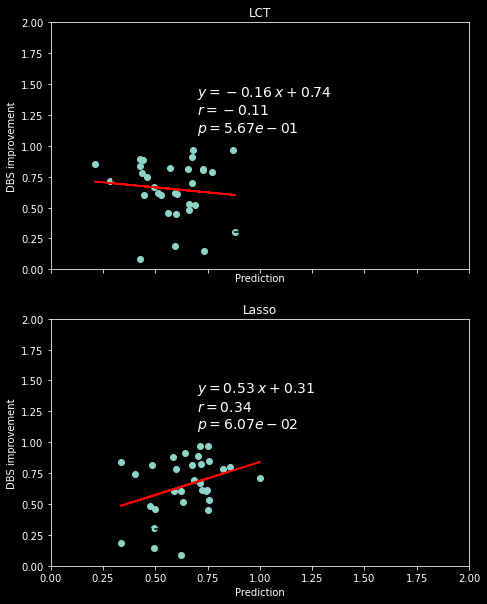

In [13]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [14]:
subsc

array([  6.,   9.,  15.,  23.,  26.,  29.,  30.,  44.,  45.,  46.,  48.,
        55.,  58.,  59.,  62.,  63.,  68.,  73.,  75.,  83.,  85.,  87.,
        90.,  92., 106., 107., 109., 110., 113., 114., 115.])

In [15]:
per_change

array([0.66666667, 0.96825397, 0.7826087 , 0.48      , 0.71428571,
       0.8125    , 0.82142857, 0.88461538, 0.1875    , 0.84848485,
       0.78461538, 0.88888889, 0.51724138, 0.74358974, 0.53225806,
       0.91176471, 0.8       , 0.8125    , 0.96774194, 0.83928571,
       0.14705882, 0.08571429, 0.30232558, 0.45614035, 0.69491525,
       0.61702128, 0.60344828, 0.60655738, 0.60526316, 0.45      ,
       0.61538462])

In [46]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
K_nz = []
c = 0

K_all_c = np.append(K_all_c,'pre updrs')
K_all_c = np.append(K_all_c,'age')
K_all_c = np.append(K_all_c,'disease duration')

for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,None,None,None,None,None,None,None,False,False,False)

    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print(stats.kurtosis)
    print('Label distribution of:',mu,sigma,kappa)
    print(sigma/mu)

    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      #K_ss = sel.transform(K_all_c.reshape(1,-1))
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls_aug[c] = est_ls.predict(X_test_ss)
    kk = 1
    while results_ls_aug[c] < 0:
        dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=kk)
        if kk == 1:
          nny = y_train[y_n]
        else:
          nny = y_train[y_n[0][0]]
        results_ls_aug[c] = nny
        kk = kk+1
        print('Using nearest neighbor')
    print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[j],2)),'and selected CV',best_cv)
    #K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
    c=c+1

      

  


<function kurtosis at 0x7f56706513b0>
Label distribution of: 0.6493797332610988 0.2356459981054766 -0.822647341233261
0.36287858403294126
Resampled to size (31,)
Resampled to size (32,)
LassoCV score for 2 is [0.50101887] from dataset of size (256, 5388)
LassoCV score for 3 is [0.48788155] from dataset of size (256, 4388)


KeyboardInterrupt: 

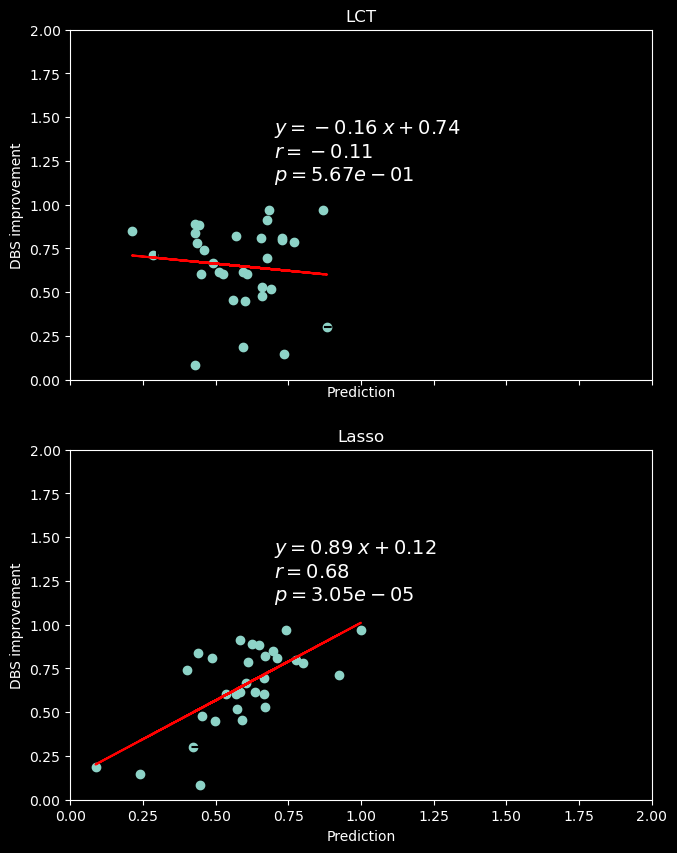

In [23]:
# pre_imp = (np.asarray(pre_updrs_off,dtype=float)-np.asarray(pre_updrs_off,dtype=float))/np.asarray(pre_updrs_off,dtype=float)
results_ls_aug[results_ls_aug>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

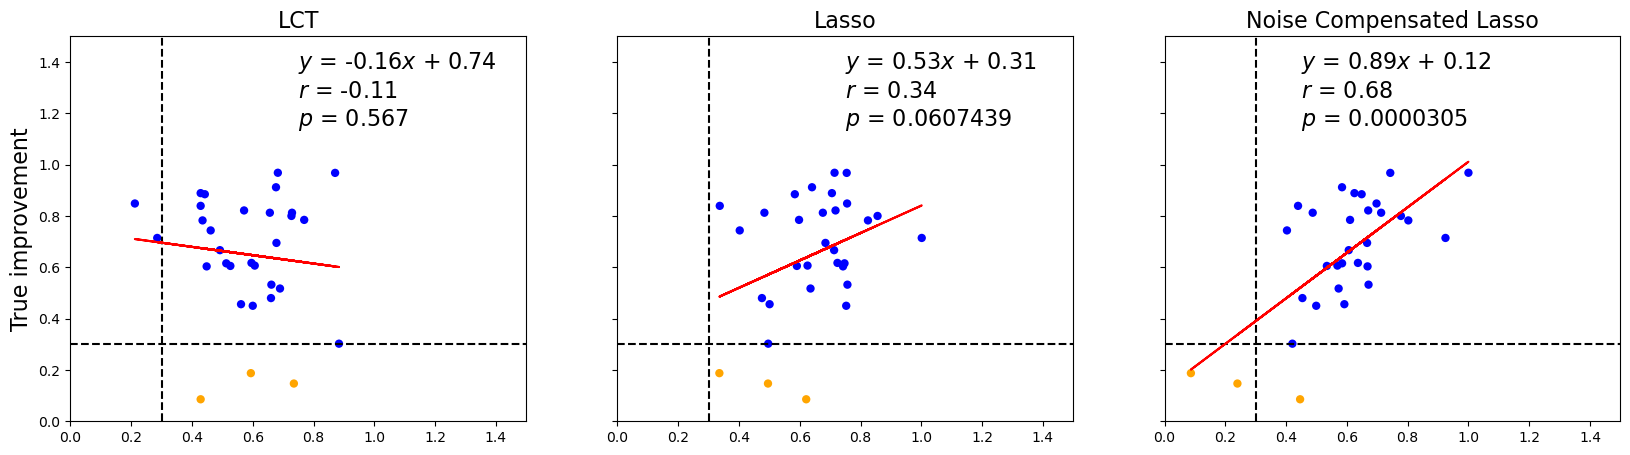

In [34]:
#pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp.T,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.50,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
ax[1].text(0.50,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Lasso',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[2].plot(results_ls_aug,y_model,color='r')
ax[2].text(1.50,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')

In [35]:
results_lsb = np.zeros_like(per_change)

In [47]:
Js = []
aug = False
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
K_nz = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,ledd,tmed,rce,loc,sex,age,dd,None,None,False,False,False)
    # 10
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    print(sigma/mu)

    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
        ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        est0 = ls0.fit(X0_ss0,y_train)
        eps = y_train-ls0.predict(X0_ss0)
        eps_v = eps*np.random.normal(0,1,1)
        y_train_0 = y_train
      if aug == True:
        y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      else: # Control for different training sample sizes
        while len(eps_v) < len(y_train):
          eps_v = np.hstack((eps_v,eps*np.random.normal(0,1,1)))
        y_train_n = y_train+eps_v
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      #K_ss = sel.transform(K_all_c)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      # plt.imshow(X0_ss)
      # plt.show()
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_lsb[c] = est_ls.predict(X_test_ss)
    if results_lsb[c] < 0:
        dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)
        results_lsb[c] = y_train[y_n]
        print('Using nearest neighbor')
    print('Lasso predicts',str(np.round(results_lsb[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
    #K_nz.append(K_ss[est_ls.coef_>0])
    c=c+1

      
  


Label distribution of: 0.6493797332610988 0.2356459981054766 -0.822647341233261
0.36287858403294126
Resampled to size (31,)


Resampled to size (32,)
LassoCV score for 2 is [0.99917335] from dataset of size (256, 1388)
LassoCV score for 3 is [0.99917335] from dataset of size (256, 3388)
LassoCV score for 4 is [0.99917335] from dataset of size (256, 1388)
Lasso predicts 0.6804 for case with 0.67 and selected CV 2
Label distribution of: 0.6393268232081887 0.228141573224618 -0.865250864641114
0.35684655319135045
Resampled to size (31,)
Resampled to size (32,)
LassoCV score for 2 is [0.97822617] from dataset of size (256, 388)
LassoCV score for 3 is [0.97822654] from dataset of size (256, 388)
LassoCV score for 4 is [0.97822664] from dataset of size (256, 1388)
Using nearest neighbor
Lasso predicts 0.74 for case with 0.97 and selected CV 4
Label distribution of: 0.6455149989615818 0.23437661211565589 -0.792722688406113
0.36308468818337236
Resampled to size (31,)
Resampled to size (32,)
LassoCV score for 2 is [0.91215412] from dataset of size (256, 5388)
LassoCV score for 3 is [0.91206114] from dataset of size (25

In [49]:
per_change

array([0.66666667, 0.96825397, 0.7826087 , 0.48      , 0.71428571,
       0.8125    , 0.82142857, 0.88461538, 0.1875    , 0.84848485,
       0.78461538, 0.88888889, 0.51724138, 0.74358974, 0.53225806,
       0.91176471, 0.8       , 0.8125    , 0.96774194, 0.83928571,
       0.14705882, 0.08571429, 0.30232558, 0.45614035, 0.69491525,
       0.61702128, 0.60344828, 0.60655738, 0.60526316, 0.45      ,
       0.61538462])

In [58]:
per_change!=0.83928571

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

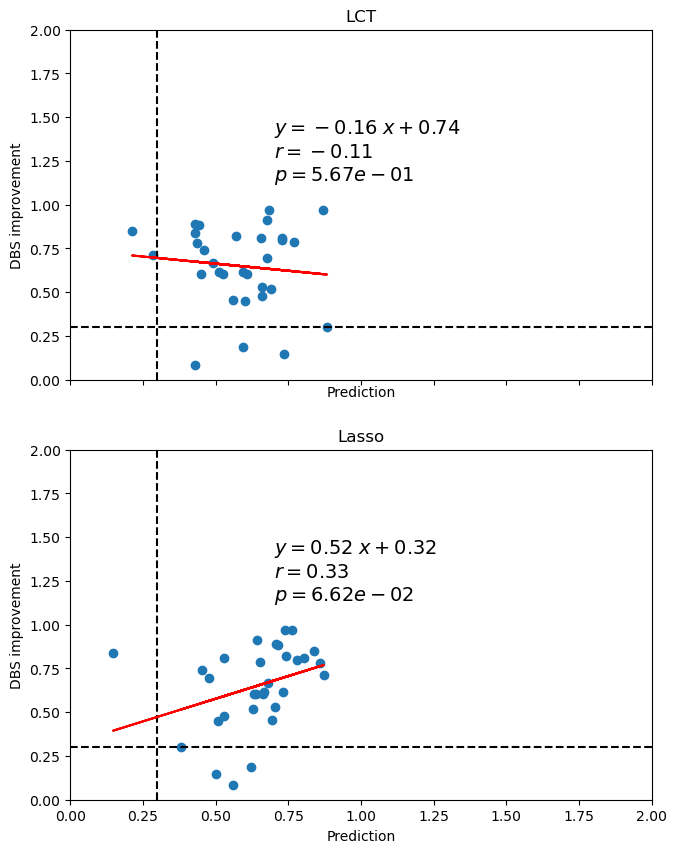

In [55]:
# pre_imp = (np.asarray(pre_updrs_off,dtype=float)-np.asarray(pre_updrs_off,dtype=float))/np.asarray(pre_updrs_off,dtype=float)
results_ls_aug[results_lsb>1] = 1
util.eval_prediction(np.vstack((pre_imp[per_change!=0.83928571],
                               results_lsb[per_change!=0.83928571],
                               )),
                               per_change[per_change!=0.83928571],
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
# from collections import Counter

# plt.rcParams["figure.figsize"] = (30,15)
# fig, axes = plt.subplots(1,1,sharey=True)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.8)

# R = [item for sublist in K_nz for item in sublist]
# letter_counts = Counter(R)
# lc = { x: count for x, count in letter_counts.items() if count > 1 }
# df = pd.DataFrame.from_dict(lc, orient='index')
# df.sort_values(0, ascending=False, inplace=True)
# df.plot(ax=axes, y=0, kind='bar', legend=False, fontsize=16)
# plt.title('Predictive radiomic features',fontsize=16)
# plt.ylabel('Frequency',fontsize=16)

# plt.style.use('default')

In [ ]:
# pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
# per_change = np.repeat(per_change,r)
# plt.rcParams['figure.figsize'] = [20, 5]
# fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
# #ax[0].scatter(pre_imp,per_change)
# col = np.where(per_change <= 0.3,'orange','blue')
# ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
# lr = stats.linregress(pre_imp,per_change)
# y_model = pre_imp*lr.slope+lr.intercept
# ax[0].plot(pre_imp,y_model,color='r')
# ax[0].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
#                     ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
# ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
# ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
# ax[0].set_title('LCT',fontsize=16)
# ax[0].set_ylabel('True improvement',fontsize=16)

# col = np.where(per_change <= 0.3,'orange','blue')
# ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
# lr = stats.linregress(np.squeeze(results_ls),per_change)
# y_model = results_ls*lr.slope+lr.intercept
# ax[1].plot(results_ls,y_model,color='r')
# ax[1].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
#                     ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
# ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
# ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
# ax[1].set_title('Lasso',fontsize=16)
# ax[1].set_xlabel('Prediction',fontsize=16)
# col = np.where(per_change <= 0.3,'orange','blue')
# ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
# lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
# y_model = results_ls_aug*lr.slope+lr.intercept
# ax[2].plot(results_ls_aug,y_model,color='r')
# ax[2].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
#                     ha='left', va='bottom', transform=ax[2].transAxes,fontsize=16) 
# ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
# ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
# ax[2].set_title('Noise Compensated Lasso',fontsize=16)
# plt.ylim([0,1.25])
# plt.xlim([0,1.25])
# plt.style.use('default')

In [ ]:
# np.save('results_ls_aug_msw.npy',results_ls_aug)